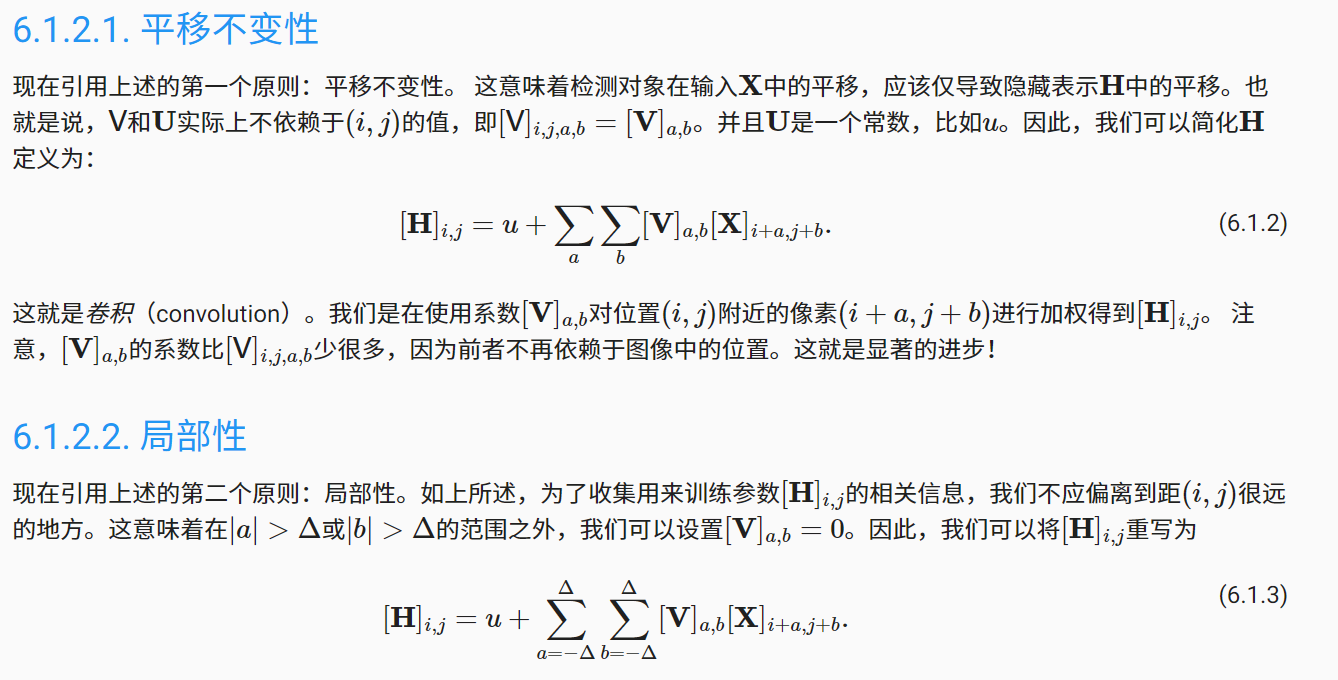

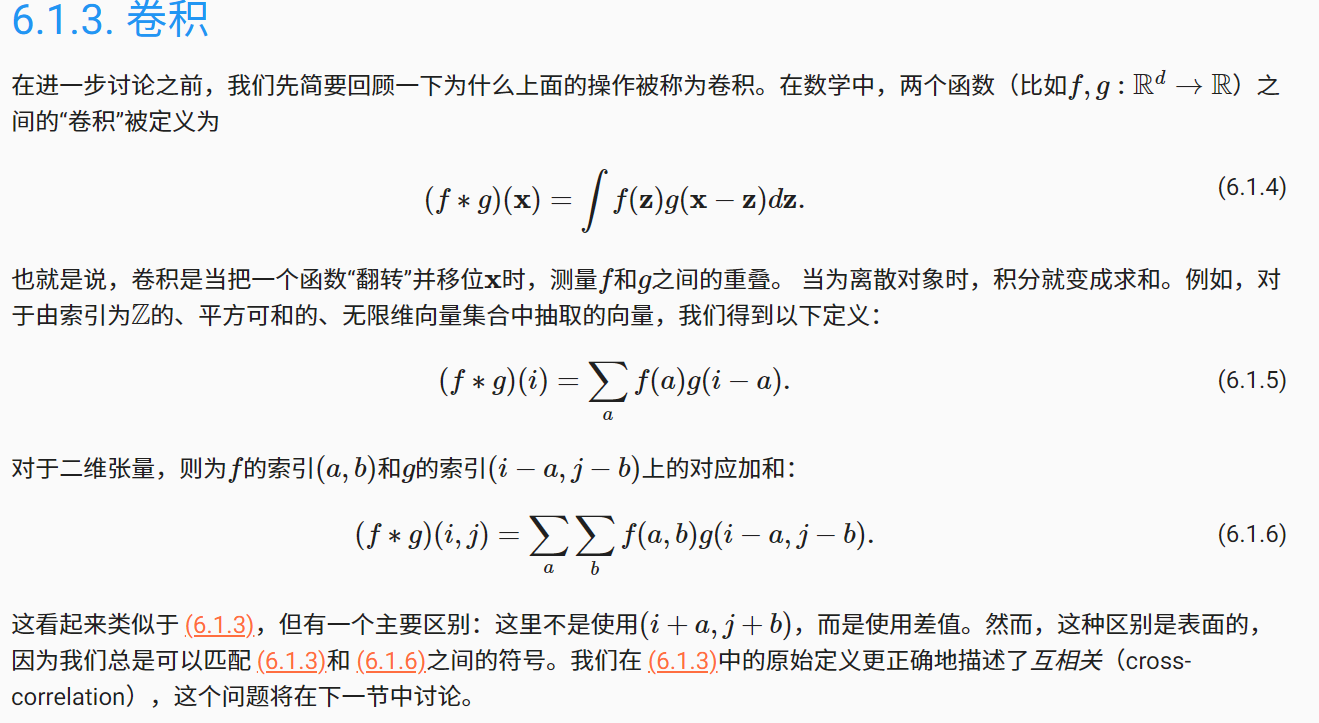

二维卷积过程

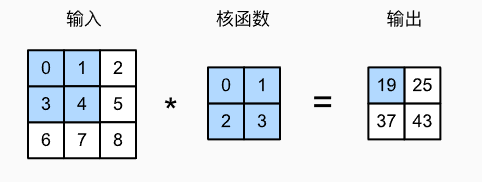

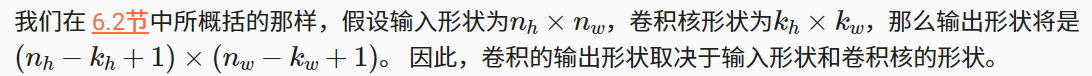

In [1]:
from mxnet import autograd, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [2]:
X = np.array([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = np.array([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

array([[19., 25.],
       [37., 43.]])

In [3]:
X = np.ones((6, 8))
X[:, 2:6] = 0
X

array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
K = np.array([[1.0, -1.0]])
K

array([[ 1., -1.]])

In [5]:
Y = corr2d(X, K)
Y

array([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [7]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2D(1, kernel_size=(1, 2), use_bias=False)
conv2d.initialize()

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1


X = X.reshape(1, 1, 6, 8)
Y = Y.reshape(1, 1, 6, 7)
lr = 3e-2  # 学习率

for i in range(10):
    with autograd.record():
        Y_hat = conv2d(X)
        l = (Y_hat - Y) ** 2
    l.backward()
    # 迭代卷积核
    conv2d.weight.data()[:] -= lr * conv2d.weight.grad()
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {float(l.sum()):.3f}')

epoch 2, loss 4.949
epoch 4, loss 0.831
epoch 6, loss 0.140
epoch 8, loss 0.024
epoch 10, loss 0.004


In [8]:
conv2d.weight.data().reshape((1, 2))

array([[ 0.9895   , -0.9873705]])

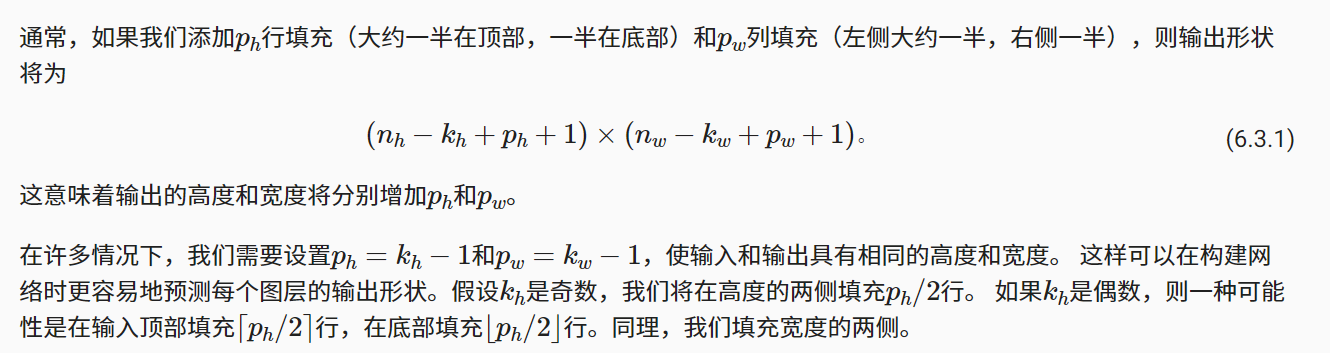

对于任何二维张量X，当满足： 1. 卷积核的大小是奇数； 2. 所有边的填充行数和列数相同； 3. 输出与输入具有相同高度和宽度 则可以得出：输出Y[i, j]是通过以输入X[i, j]为中心，与卷积核进行互相关计算得到的。

In [9]:
from mxnet import np, npx
from mxnet.gluon import nn

npx.set_np()

# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2D(1, kernel_size=3, padding=1)
X = np.random.uniform(size=(8, 8))
comp_conv2d(conv2d, X).shape

(8, 8)

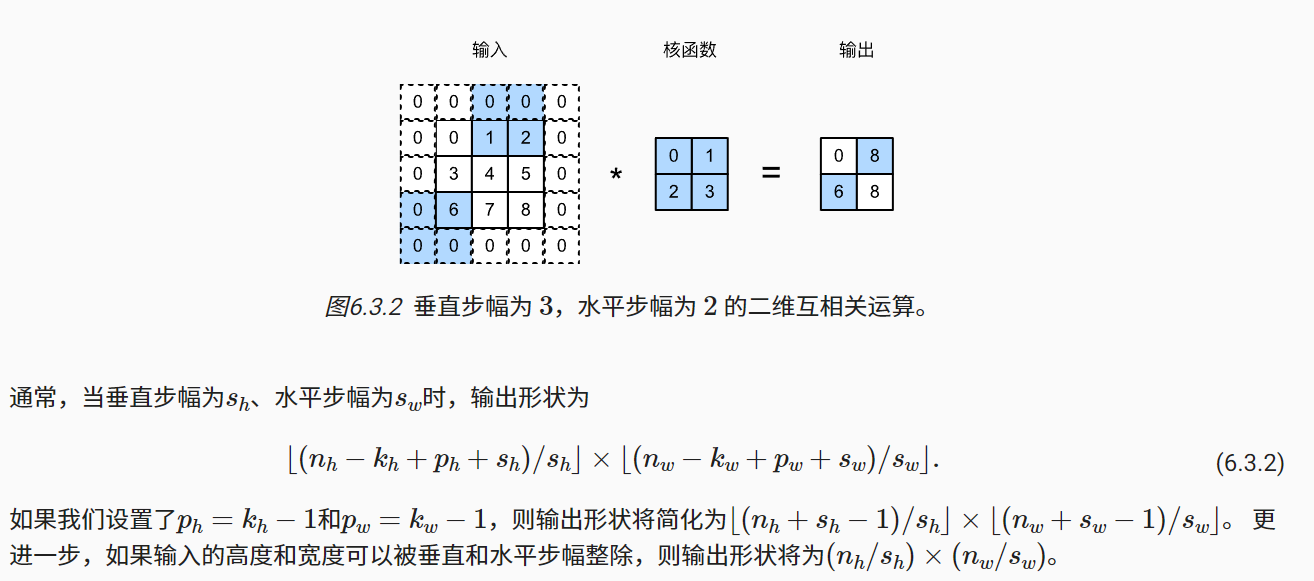

一般向下取整，2.5取2

In [12]:
conv2d = nn.Conv2D(1, kernel_size=(6, 5), padding=(0, 1), strides=(3, 4))
comp_conv2d(conv2d, X).shape

(1, 2)

卷积多输入多输出的例子

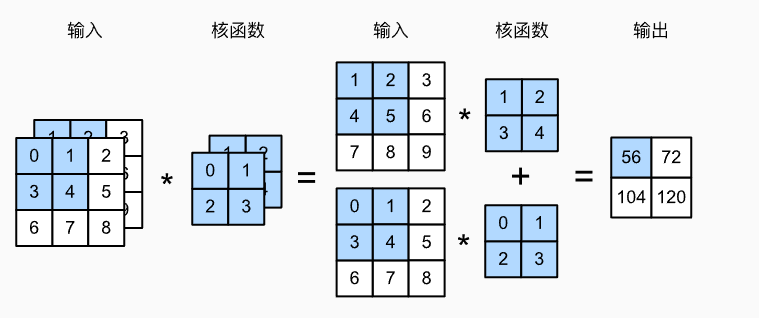

In [13]:
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [17]:
X = np.array([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = np.array([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

print(X.shape)
print(K.shape)
corr2d_multi_in(X, K)

(2, 3, 3)
(2, 2, 2)


array([[ 56.,  72.],
       [104., 120.]])

## 汇聚层


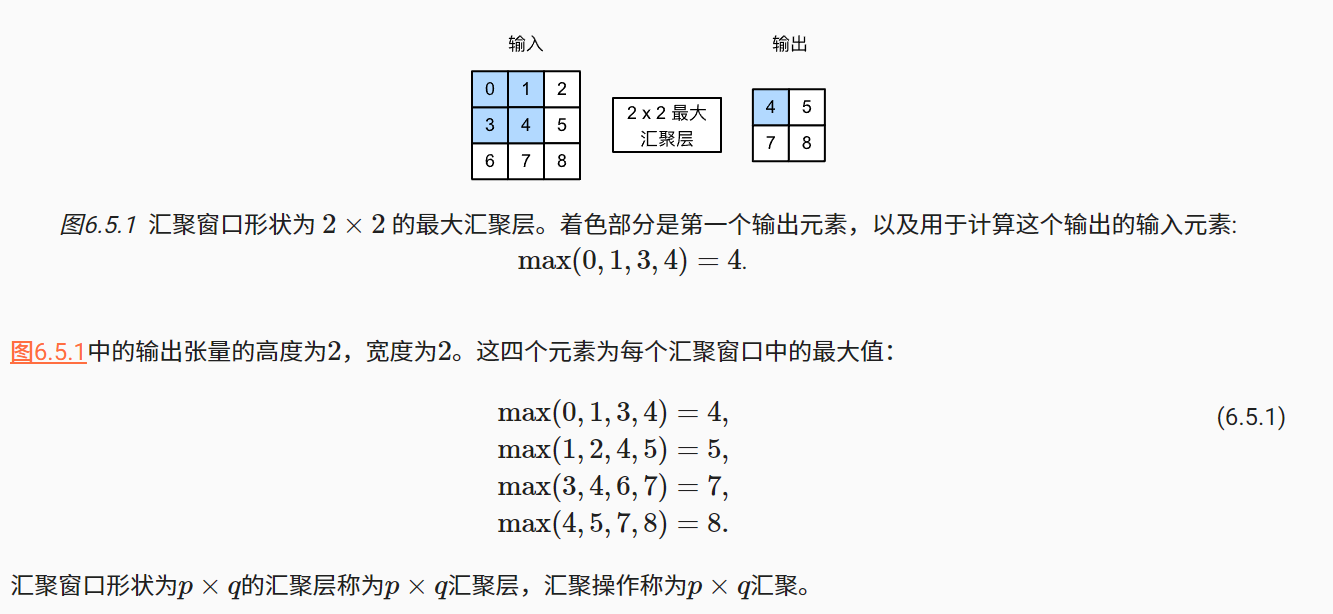

汇聚（pooling）层，它具有双重目的：降低卷积层对位置的敏感性，同时降低对空间降采样表示的敏感性。

In [18]:
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = np.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [19]:
X = np.array([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

array([[4., 5.],
       [7., 8.]])

## LeNet


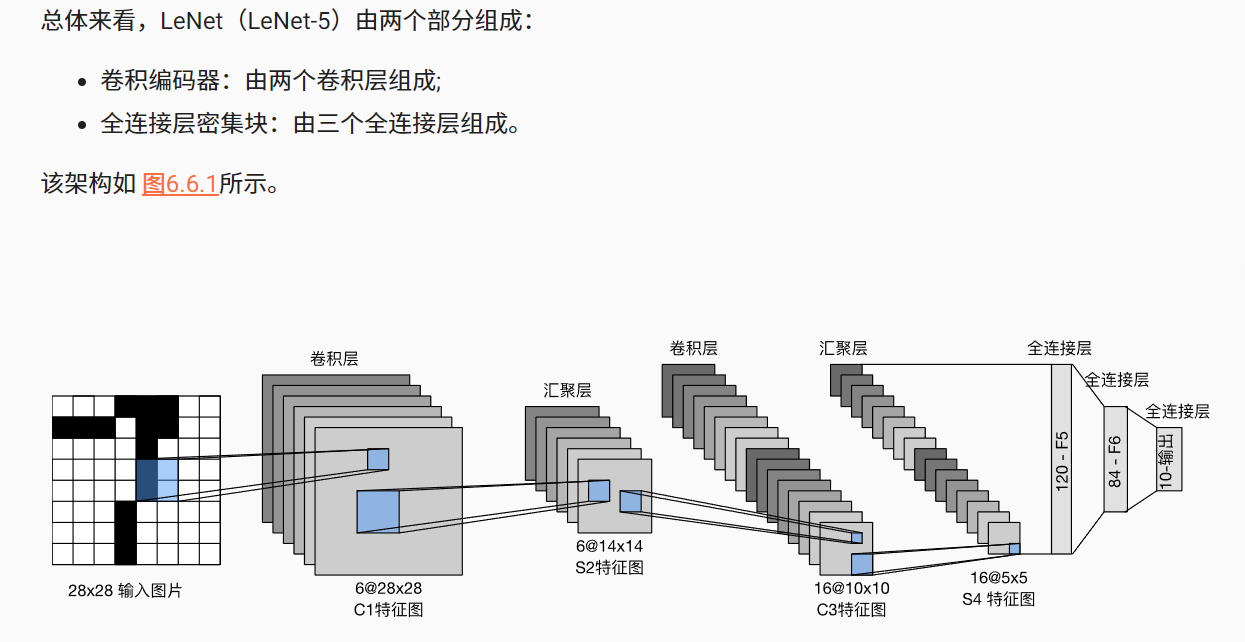

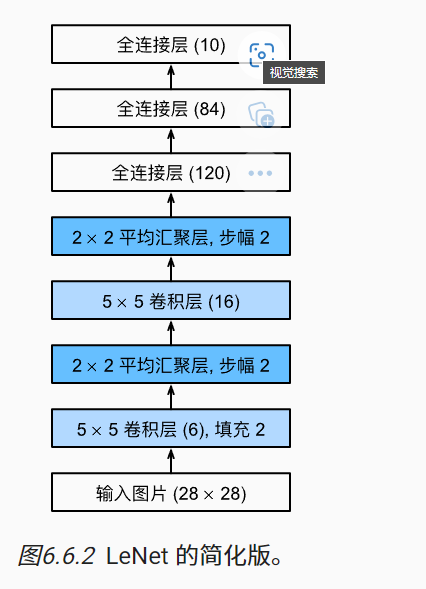

In [20]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        # 默认情况下，“Dense”会自动将形状为（批量大小，通道数，高度，宽度）的输入，
        # 转换为形状为（批量大小，通道数*高度*宽度）的输入
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

In [21]:
X = np.random.uniform(size=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv5 output shape:	 (1, 6, 28, 28)
pool0 output shape:	 (1, 6, 14, 14)
conv6 output shape:	 (1, 16, 10, 10)
pool1 output shape:	 (1, 16, 5, 5)
dense0 output shape:	 (1, 120)
dense1 output shape:	 (1, 84)
dense2 output shape:	 (1, 10)


In [22]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [23]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """使用GPU计算模型在数据集上的精度"""
    if not device:  # 查询第一个参数所在的第一个设备
        device = list(net.collect_params().values())[0].list_ctx()[0]
    metric = d2l.Accumulator(2)  # 正确预测的数量，总预测的数量
    for X, y in data_iter:
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [24]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # 训练损失之和，训练准确率之和，样本数
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # 下面是与“d2l.train_epoch_ch3”的主要不同
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.475, train acc 0.819, test acc 0.812
2802.2 examples/sec on cpu(0)


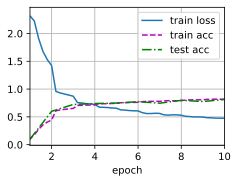

In [25]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())